## Mono/Di-derm phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_diderm_data, pca_run_and_plot, tsne_plot, plot_accuracy_metric

TAX_LEVEL = "phylum"
DATA_DIRECTORY = "data_diderm"
RANDOM_SEED = 42
OUTPUT_DIRECTORY = f"../{DATA_DIRECTORY}/plots_{TAX_LEVEL}_tax_level"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/train_taxa_names_{TAX_LEVEL}_tax_level"
X_val_train, y_label_train, X_column_names, taxa_group_names_train = read_diderm_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/test_taxa_names_{TAX_LEVEL}_tax_level"
X_val_test, y_label_test, X_column_names, taxa_group_names_test = read_diderm_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

In [2]:
num_mono_train = float(sum(y_label_train.cpu()))
num_di_train = float(len(y_label_train.cpu()) - num_mono_train)
print(f"Number of Monoderms in train = {num_mono_train}, which is {round(100*num_mono_train/(num_mono_train+num_di_train),2)} %")
print(f"Number of Diderms = {num_di_train}, which is {round(100*num_di_train/(num_mono_train+num_di_train),2)} %\n")

num_mono_test = float(sum(y_label_test.cpu()))
num_di_test = float(len(y_label_test.cpu()) - num_mono_test)
print(f"Number of Monoderms in test = {num_mono_test}, which is {round(100*num_mono_test/(num_mono_test+num_di_test),2)} %")
print(f"Number of Diderms = {num_di_test}, which is {round(100*num_di_test/(num_mono_test+num_di_test),2)} %")

Number of Monoderms in train = 258.0, which is 34.86 %
Number of Diderms = 482.0, which is 65.14 %

Number of Monoderms in test = 58.0, which is 31.18 %
Number of Diderms = 128.0, which is 68.82 %


#### 2. PCA and tSNE projections

In [3]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Shape of the projected data = (740, 2)


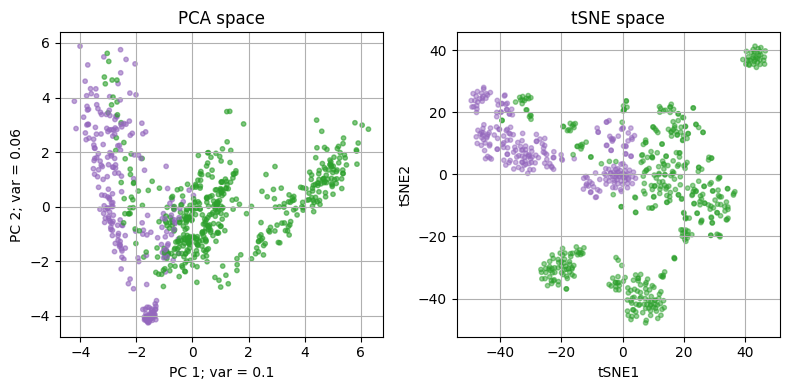

In [4]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, y_label_train.cpu(), colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phenot.pdf", format="pdf")
plt.show()

Shape of the projected data = (740, 2)


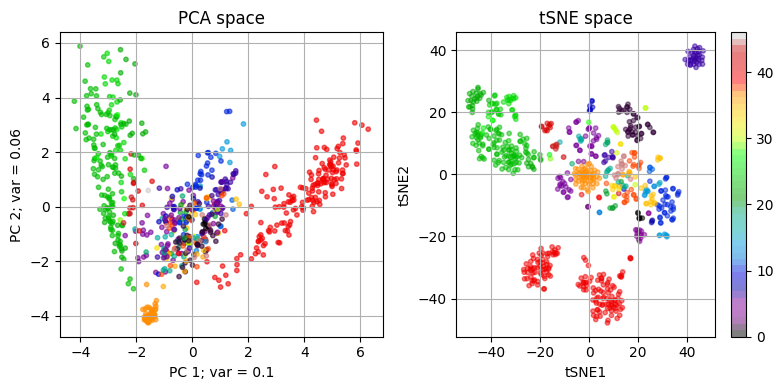

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# Put to True, if a legend is needed (it might be too longr for some taxonomy levels)
legend = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, label_encoder.fit_transform(taxa_group_names_train), taxa_group_names_train, None, legend);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, label_encoder.fit_transform(taxa_group_names_train), None);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phylogen.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection

First, find baseline (for all GOGs) test and cross-validation accuracy measures.

In [6]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [7]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


XGBoost baseline test accuracy (all features) = {'accuracy': 0.9946236559139785, 'precision': 0.9830508474576272, 'recall': 1.0, 'f1': 0.9914529914529915, 'roc_auc': 0.9935344827586207}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9946236559139785, 'precision': 0.9830508474576272, 'recall': 1.0, 'f1': 0.9914529914529915, 'roc_auc': 0.9935344827586207}


In [8]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

In [9]:
from feature_selection.feature_selection_utils import random_feat_removal_curves

num_runs=4
feat_step = 100

feat_removal = False
cv_accur_arr_all_runs_mn, cv_accur_arr_all_runs_std, test_accur_arr_all_runs_mn, test_accur_arr_all_runs_std, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);    

In [10]:
feat_removal = True
cv_accur_arr_all_runs_mn_rem, cv_accur_arr_all_runs_std_rem, test_accur_arr_all_runs_mn_rem, test_accur_arr_all_runs_std_rem, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);

#### 3.1 Feature selection with Mutual Information

In [11]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

In [12]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG1127', 'COG1519', 'COG0854', 'COG1212', 'COG1663', 'COG0774', 'COG4783']


Shape of the projected data = (740, 2)


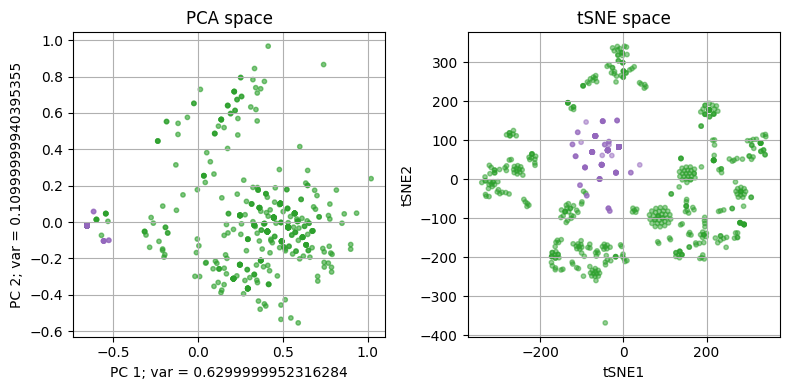

In [13]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_mi_feat.pdf", format="pdf")
plt.show()


In [14]:
feat_step = 100
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [15]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [16]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.9635135135135136, 'precision': 0.9080598613549136, 'recall': 1.0, 'f1': 0.951141503530884, 'roc_auc': 0.9719394329896908}
{'accuracy': 0.8602150537634409, 'precision': 0.6904761904761905, 'recall': 1.0, 'f1': 0.8169014084507042, 'roc_auc': 0.8984375}


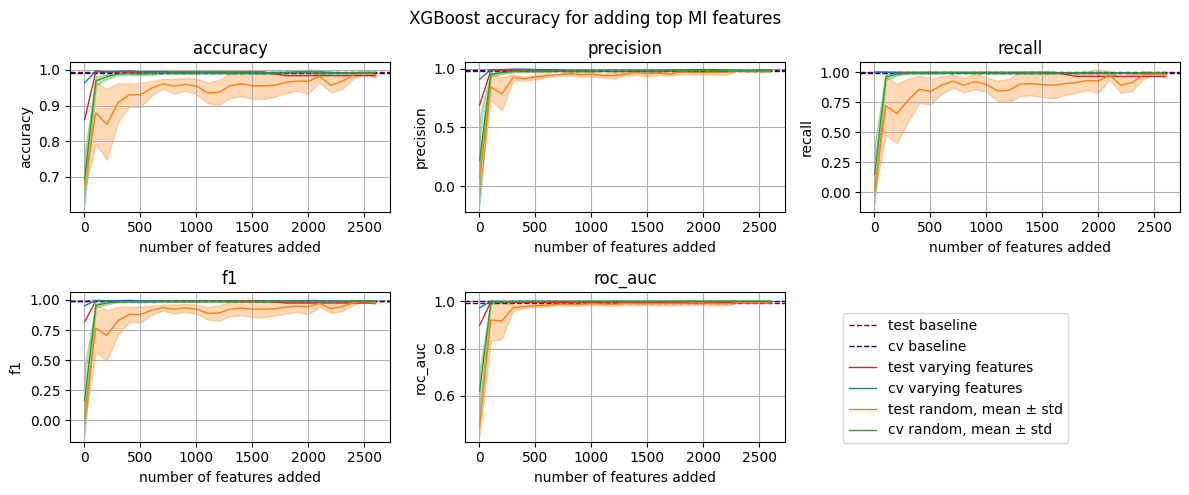

In [17]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf")   

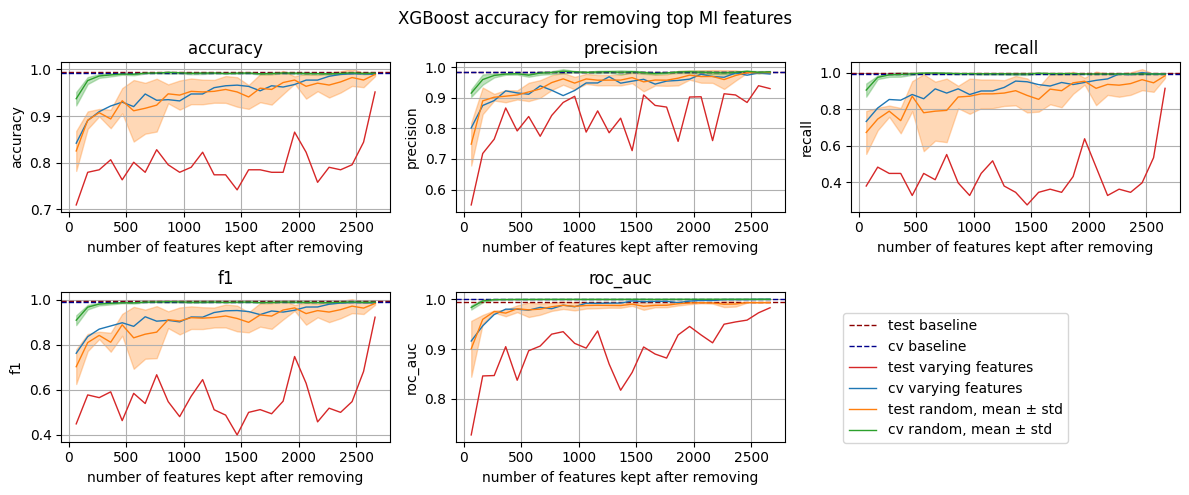

In [18]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf")  

#### 3.2 Feature selection with Random Forest

In [19]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

Original feature count: 2665, Selected feature count: 316


In [20]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0767', 'COG1519', 'COG0763', 'COG1663', 'COG1127', 'COG1212', 'COG4783', 'COG0795', 'COG0854', 'COG0774']


In [21]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Shape of the projected data = (740, 2)


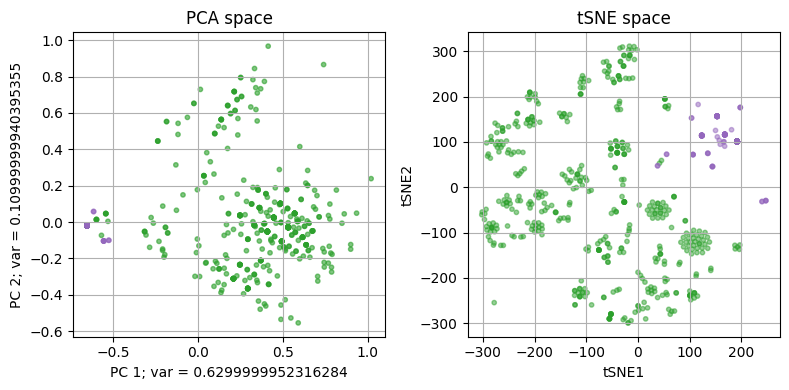

In [22]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [23]:
feat_step = 100
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [24]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.927027027027027, 'precision': 0.8359486490520973, 'recall': 0.9923076923076923, 'f1': 0.9062585669526977, 'roc_auc': 0.9421912172878668}
{'accuracy': 0.9032258064516129, 'precision': 0.8703703703703703, 'recall': 0.8103448275862069, 'f1': 0.8392857142857143, 'roc_auc': 0.9185748922413792}


In [25]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

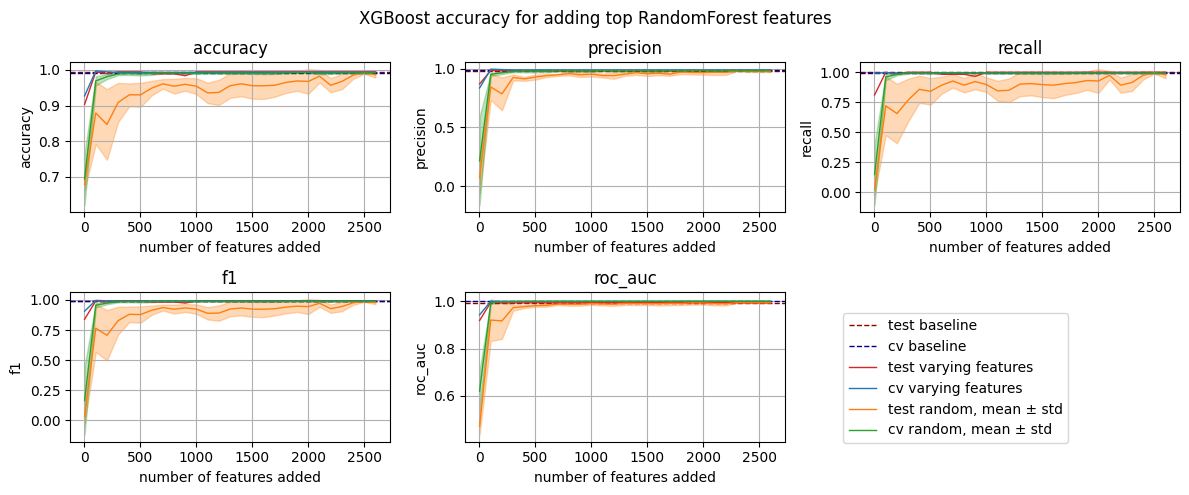

In [26]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf") 

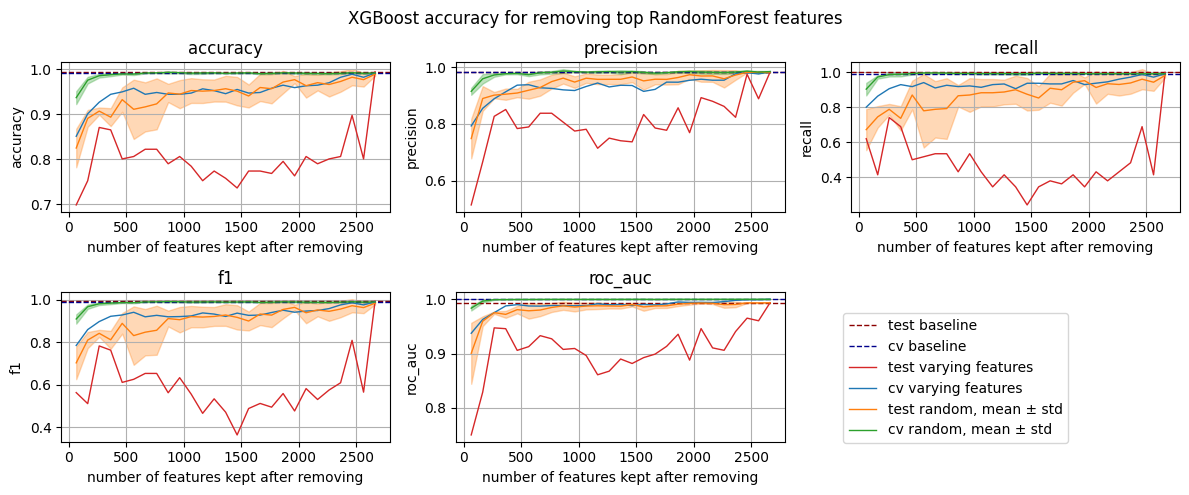

In [27]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf")  

#### 3.3 Feature selection with SHAP values

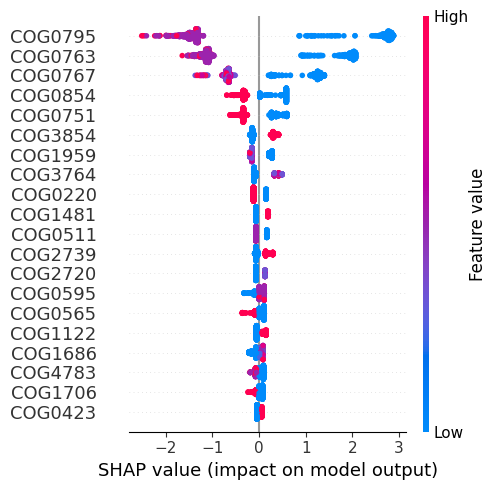

In [28]:
from feature_selection.feature_selection_utils import shap_features

device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [29]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG0854', 'COG0751', 'COG3854', 'COG1959', 'COG3764', 'COG0220', 'COG1481']


Shape of the projected data = (740, 2)


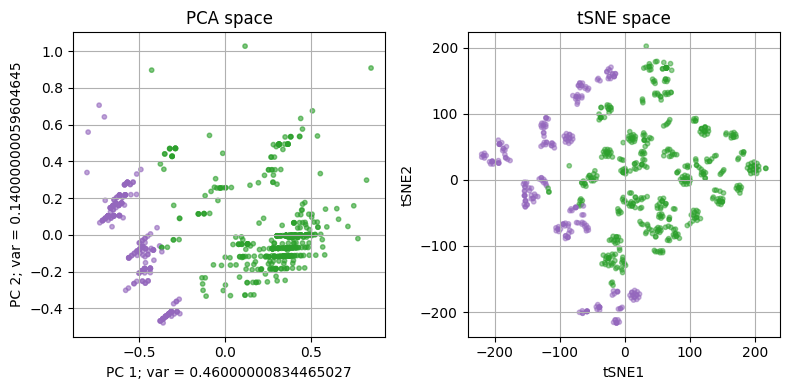

In [30]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [31]:
feat_step = 100
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [32]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

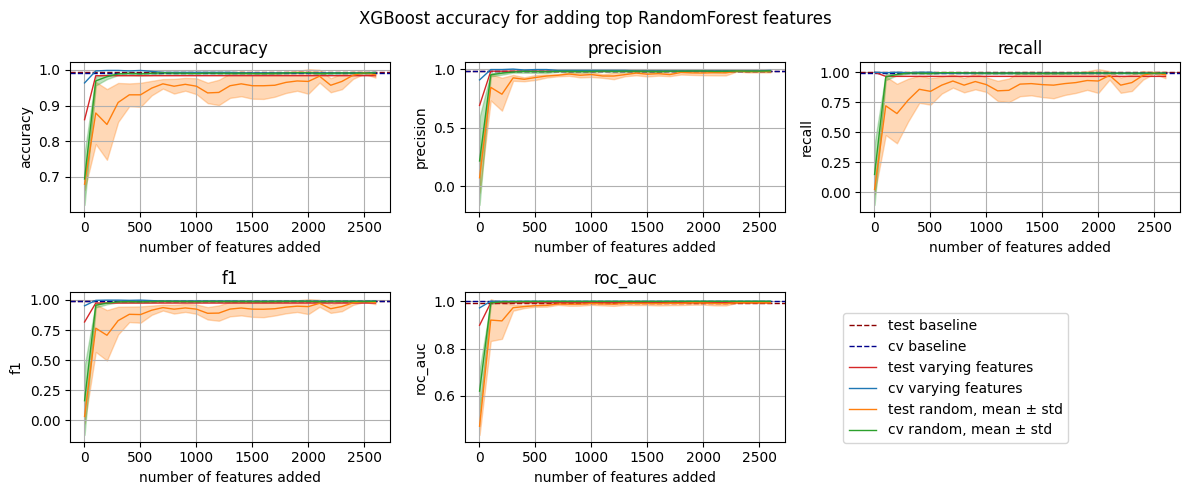

In [33]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_add.pdf", format="pdf") 

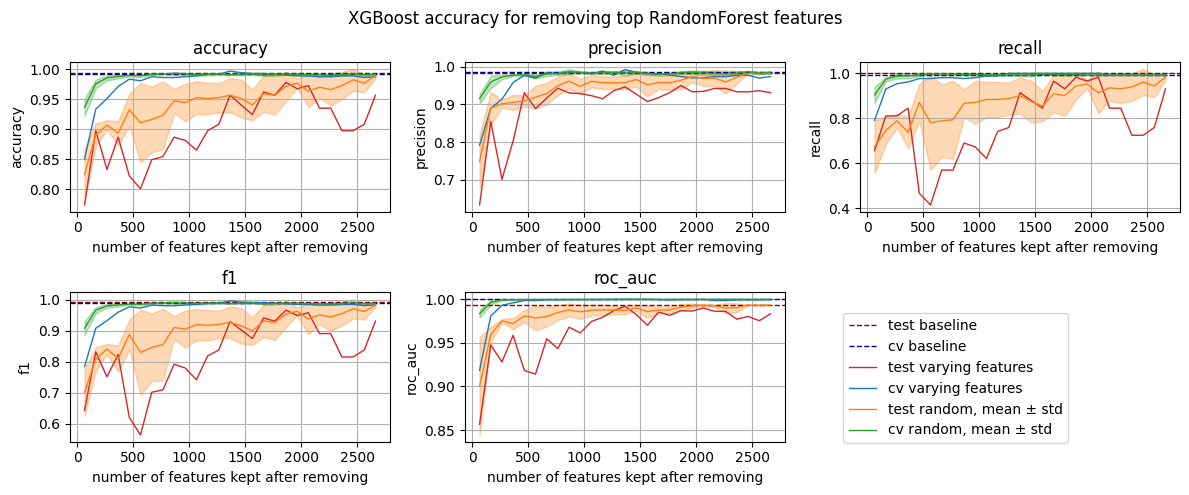

In [34]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_remov.pdf", format="pdf")  

#### 4. Feature comparison

In [38]:
import pandas as pd
from feature_selection.feature_selection_utils import make_cog_descr

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)
make_cog_descr(df)

,MI,RandomForest,SHAP
0,COG0795: Lipopolysaccharide export LptBFGC sys...,COG0767: Permease subunit MlaE of the ABC-type...,COG0795: Lipopolysaccharide export LptBFGC sys...
1,COG0763: Lipid A disaccharide synthetase,COG1519: 3-deoxy-D-manno-octulosonic-acid tran...,COG0763: Lipid A disaccharide synthetase
2,COG0767: Permease subunit MlaE of the ABC-type...,COG0763: Lipid A disaccharide synthetase,COG0767: Permease subunit MlaE of the ABC-type...
3,COG1127: ATPase subunit MlaF of the ABC-type i...,COG1663: Tetraacyldisaccharide-1-P 4'-kinase (...,COG0854: Pyridoxine 5'-phosphate synthase PdxJ
4,COG1519: 3-deoxy-D-manno-octulosonic-acid tran...,COG1127: ATPase subunit MlaF of the ABC-type i...,"COG0751: Glycyl-tRNA synthetase, beta subunit"
5,COG0854: Pyridoxine 5'-phosphate synthase PdxJ,COG1212: CMP-2-keto-3-deoxyoctulosonic acid sy...,COG3854: Stage III sporulation protein SpoIIIAA
6,COG1212: CMP-2-keto-3-deoxyoctulosonic acid sy...,COG4783: Periplasmic chaperone/metalloprotease...,COG1959: DNA-binding transcriptional regulator...
7,COG1663: Tetraacyldisaccharide-1-P 4'-kinase (...,COG0795: Lipopolysaccharide export LptBFGC sys...,COG3764: Sortase (surface protein transpeptidase)
8,COG0774: UDP-3-O-acyl-N-acetylglucosamine deac...,COG0854: Pyridoxine 5'-phosphate synthase PdxJ,COG0220: tRNA G46 N7-methylase TrmB
9,COG4783: Periplasmic chaperone/metalloprotease...,COG0774: UDP-3-O-acyl-N-acetylglucosamine deac...,COG1481: DNA-binding transcriptional regulator...


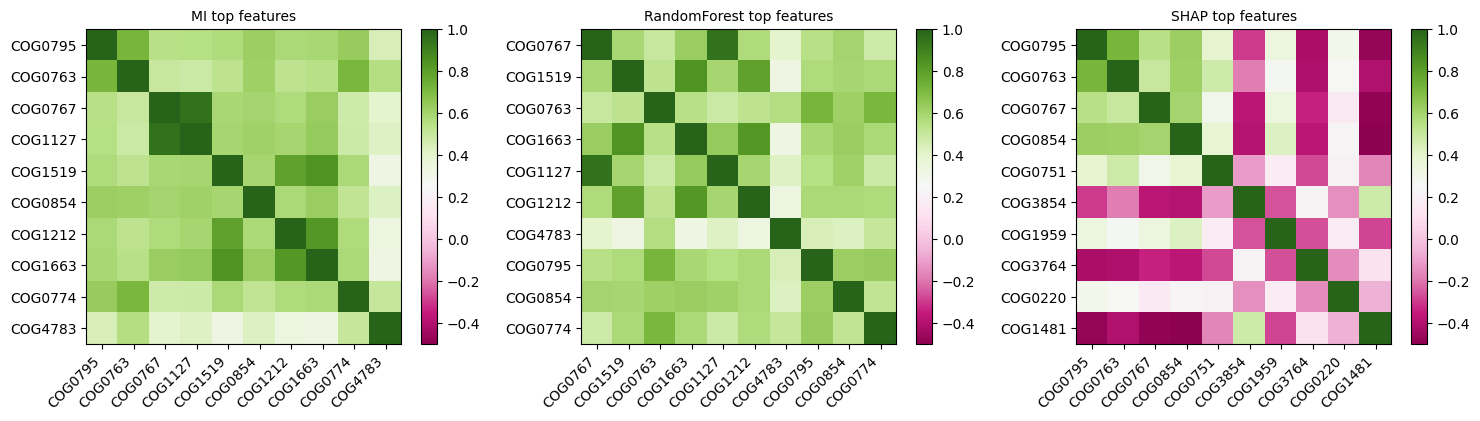

In [36]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")
plt.show()
